In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from airbnb_prices import DataPipeline
from airbnb_prices.eval import train_eval


### DataPipeline

The `DataPipeline` object offers a high-level wrapper to manager the entire data engineering pipeline. It is controlled by a configuration file, in this example `./config.json`.

In [2]:
pipeline = DataPipeline.from_file("../data/train_airbnb_berlin.csv", "./config.json")

`pipeline.run()` is in charge of data preprocessing. It will: 
* Replace NaNs
* Engineer new features
* One-hot encode categoricals
* Standardize selected features
* Drop unused features

In [3]:
pipeline.run()

Training, validation and test data can be easily accessed:

In [4]:
X_train, y_train = pipeline.train_data
X_val, y_val = pipeline.val_data

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

X_val

(10724, 21) (10724,)
(2311, 21) (2311,)


,Accomodates,Bathrooms,Bedrooms,Beds,Delta between Last Review and First Review,Distance to Berlin Cathedral,Guests Included,Host Response Rate,Host Since Duration from max,Instant Bookable,...,Longitude,Min Nights,Overall Rating,Property Type_Apartment,Property Type_Condominium,Property Type_Hotel,Property Type_House,Property Type_Loft,Reviews,Room Type_Entire home/apt
14977,0.989066,-0.316556,-0.237678,0.366454,-0.495703,0.216792,0.933196,0.285510,-1.729101,1.409975,...,-0.460994,-0.319245,0.764936,1,0,0,0,0,0.213678,1
9464,-1.157226,-0.316556,-0.237678,-0.549555,0.050092,-0.553849,-0.445312,-6.657864,-1.011436,-0.709232,...,0.072546,0.089561,0.295022,1,0,0,0,0,-0.494908,0
1496,-0.441796,-0.316556,-0.237678,-0.549555,-1.041498,-0.366240,-0.445312,0.285510,-0.696694,1.409975,...,-0.527835,-0.182976,0.764936,1,0,0,0,0,-0.368375,1
11583,0.273635,-0.316556,1.403780,0.366454,-0.848752,0.202243,-0.445312,0.285510,-0.125547,-0.709232,...,0.769192,-0.182976,0.295022,1,0,0,0,0,-0.469602,1
542,0.273635,-0.316556,-0.237678,-0.549555,-0.585396,0.951475,-0.445312,0.285510,-1.087408,-0.709232,...,-1.641347,1.656652,0.138384,1,0,0,0,0,-0.343068,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723,0.273635,-0.316556,-0.237678,0.366454,0.050092,-0.481087,-0.445312,0.285510,0.554132,-0.709232,...,0.428692,0.021427,0.295022,1,0,0,0,0,-0.494908,1
11140,0.273635,-0.316556,-0.237678,0.366454,-0.463260,-0.660012,0.933196,0.285510,0.252957,-0.709232,...,0.249428,-0.251111,0.295022,1,0,0,0,0,0.289598,0
1097,-1.157226,-0.316556,-0.237678,-0.549555,-1.152183,2.271798,-0.445312,0.285510,-1.315324,1.409975,...,2.288683,-0.251111,-7.066961,1,0,0,0,0,-0.444295,0
6627,0.989066,-0.316556,-0.237678,-0.549555,-0.944171,-0.771817,-0.445312,0.285510,0.992328,-0.709232,...,0.274260,0.293964,0.764936,1,0,0,0,0,-0.469602,1


# Model

In [5]:
model = xgb.XGBRegressor()

## Training

In [7]:
model, train_score, val_score = train_eval.train_eval_once(
    model=model, x_train=X_train, y_train=y_train, x_test=X_val, y_test=y_val
)
print("RMSE score on train set: {}".format(train_score))
print("RMSE score on val set: {}".format(val_score))

RMSE score on train set: 18.266776004182
RMSE score on val set: 43.908912920323395


## Visualization

### Feature Importance

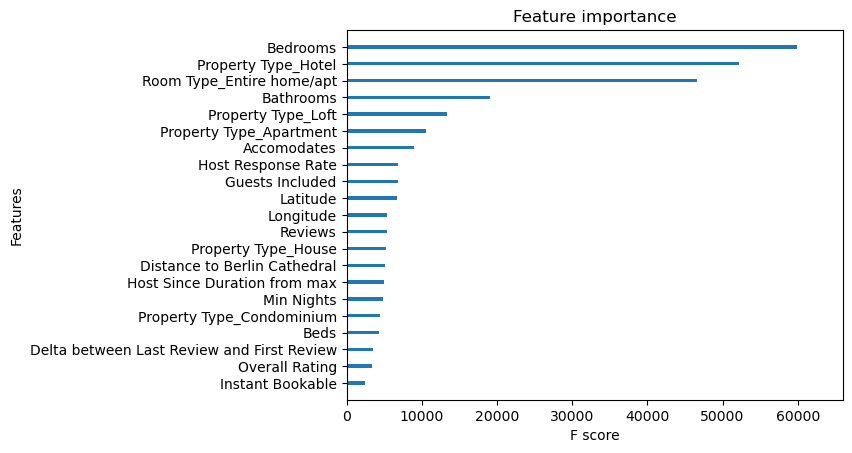

In [8]:
xgb.plot_importance(model, importance_type="gain", show_values=False)
plt.grid(False)

### Tree Visualization

<AxesSubplot: title={'center': 'Tree #4'}>

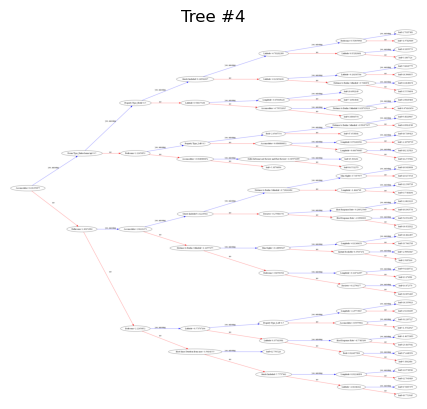

In [10]:
fig, ax = plt.subplots()
ax.set_title("Tree #4")
xgb.plot_tree(model, num_trees=3, ax=ax, rankdir="LR")

# Testing

In [11]:
x_test, y_test = pipeline.test_data

y_pred = model.predict(x_test)
test_score = np.sqrt(mean_squared_error(y_test, y_pred))
print(" RMSE score on test set: {}".format(test_score))

 RMSE score on test set: 35.692471442763846


### Visualize relative error

In [12]:
comparaison = pd.DataFrame()
y_test = y_test.reset_index()["Price"]
comparaison["Prediction"] = y_pred
comparaison["Real Value"] = y_test
comparaison["Error (%)"] = abs(comparaison["Prediction"] - comparaison["Real Value"]) / comparaison["Real Value"] * 100
comparaison.sort_values(by="Error (%)", inplace=True)

comparaison

,Prediction,Real Value,Error (%)
1250,44.959194,45.0,0.090680
1533,34.930504,35.0,0.198560
302,50.105495,50.0,0.210991
2117,49.887905,50.0,0.224190
81,38.905624,39.0,0.241989
...,...,...,...
2159,91.068321,19.0,379.306954
672,67.065201,13.0,415.886160
929,62.829014,12.0,423.575115
2280,304.717957,50.0,509.435913


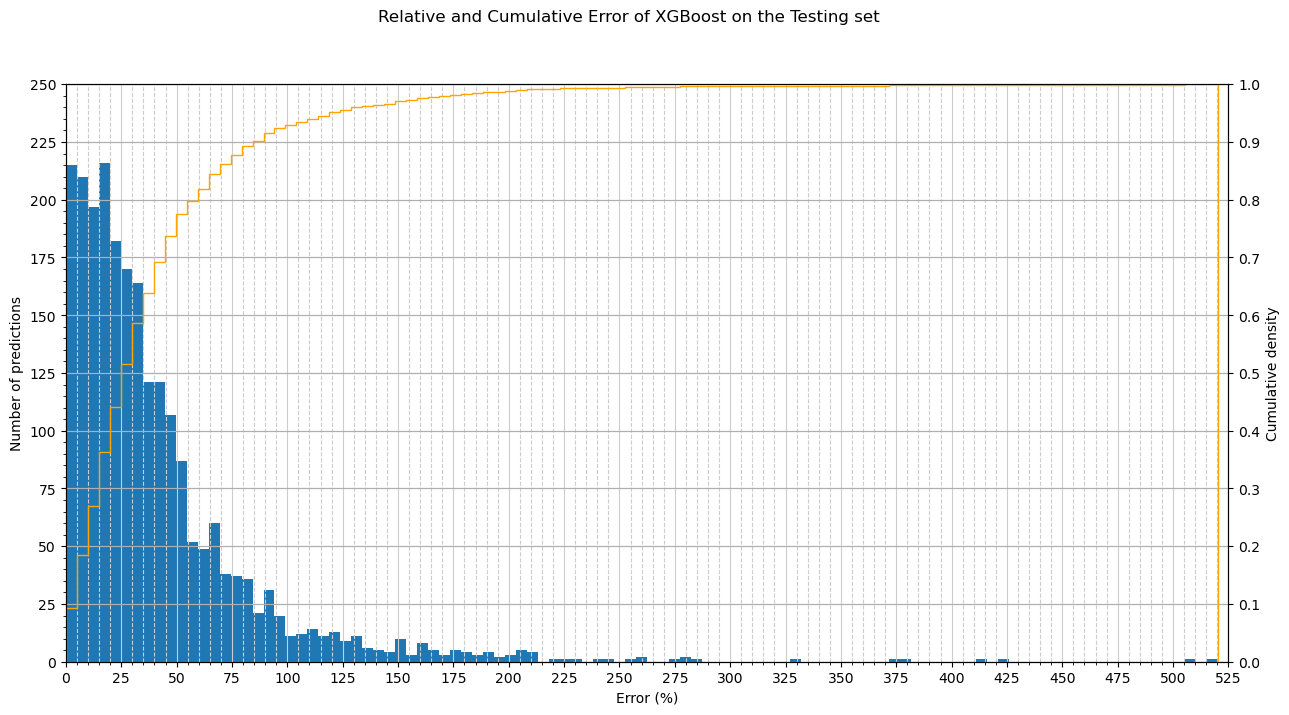

In [13]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig = plt.figure(figsize=(15,7.5))
fig.suptitle("Relative and Cumulative Error of XGBoost on the Testing set")

ax = fig.subplots(1,1)

comparaison["Error (%)"].hist(bins = 105, ax=ax)
ax.set_xlabel("Error (%)")
ax.set_ylabel("Number of predictions")

ax.set_xlim(0, 525)
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))

ax.set_ylim(0, 250)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.xaxis.grid(which='major', color='#CCCCCC', linestyle='-')
ax.xaxis.grid(which='minor', color='#CCCCCC', linestyle='--')

ax = ax.twinx()
comparaison["Error (%)"].hist(bins = 105, ax=ax, cumulative=True, density=True, histtype='step', color='orange')
ax.set_xlabel("Error (%)")
ax.set_ylabel("Cumulative density")

ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))